In [1]:
!pip install torch matplotlib numpy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=100, out_dim=1, num_hidden=6):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Differential equation: y' + y = 0 on [0, 1], with y(0) = 1
# Physics residual r(x) = dy/dx + y


def compute_residual(model, x):
    x.requires_grad_(True)
    y = model(x)
    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
    )[0]
    residual = dy_dx + y
    return residual


@torch.no_grad()
def exact_solution(x):
    return torch.exp(-x)


def train_pinn(
    num_epochs=5000,
    num_collocation=5120,
    lr=1e-3,
    lambda_residual=1.0,
    lambda_bc=10.0
              ):
    start = time.time()
    model = MLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Collocation points in [0, 1]
    x_col = torch.empty(num_collocation, 1, device=device).uniform_(-2.0, 2.0)
    # Boundary condition at x=0: y(0) = 1
    x_bc = torch.zeros((1, 1), device=device)
    y_bc_target = torch.ones((1, 1), device=device)

    for _ in range(num_epochs):
        optimizer.zero_grad()

        # Residual loss over collocation points
        residual = compute_residual(model, x_col)
        loss_res = torch.mean(residual**2)

        # Boundary loss at x=0
        y0 = model(x_bc)
        loss_bc = torch.mean((y0 - y_bc_target) ** 2)

        loss = lambda_residual * loss_res + lambda_bc * loss_bc
        loss.backward()
        optimizer.step()

        if _ % 100 == 0:
            print(f"loss={loss.item():.4e} res={loss_res.item():.4e} bc={loss_bc.item():.4e}",_)

    save_path = "trained_model.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': num_epochs
    }, save_path)
    end = time.time()
    print("TIEMPO",end-start," S")
    return model


if __name__ == "__main__":
    model = train_pinn()
    #loaded = torch.load("testing/trained_model_colab.pth",
    #                   map_location=torch.device('cpu'))
    #model = MLP()
    #model.load_state_dict(loaded['model_state_dict'])
    model.eval()

    x = torch.tensor([15.0]).to(device)
    x.requires_grad_(True)
    y = model(x)
    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
    )[0]
    residual = dy_dx + y
    print("derivative", dy_dx)
    print("value", y)
    print("residual", residual)

loss=9.8714e+00 res=1.5731e-03 bc=9.8698e-01 0
loss=5.1250e-01 res=4.8205e-01 bc=3.0456e-03 100
loss=4.1561e-01 res=3.9691e-01 bc=1.8699e-03 200
loss=3.6999e-01 res=3.0021e-01 bc=6.9776e-03 300
loss=3.4964e-01 res=3.4935e-01 bc=2.9341e-05 400
loss=1.5170e-01 res=1.4509e-01 bc=6.6110e-04 500
loss=2.1032e-01 res=2.0005e-01 bc=1.0262e-03 600
loss=1.9571e-01 res=1.6760e-01 bc=2.8112e-03 700
loss=8.9915e-02 res=8.5878e-02 bc=4.0369e-04 800
loss=1.6548e-01 res=1.3380e-01 bc=3.1686e-03 900
loss=5.2165e-02 res=5.0033e-02 bc=2.1318e-04 1000
loss=1.6449e-02 res=1.5904e-02 bc=5.4470e-05 1100
loss=5.5033e-02 res=5.1525e-02 bc=3.5087e-04 1200
loss=1.4353e-02 res=1.3872e-02 bc=4.8103e-05 1300
loss=5.1910e-03 res=5.0778e-03 bc=1.1320e-05 1400
loss=2.0734e-02 res=1.4817e-02 bc=5.9165e-04 1500
loss=4.8737e-03 res=4.7736e-03 bc=1.0010e-05 1600
loss=2.2302e-03 res=2.2021e-03 bc=2.8107e-06 1700
loss=1.1927e-01 res=3.2059e-02 bc=8.7211e-03 1800
loss=3.0294e-03 res=2.9576e-03 bc=7.1716e-06 1900
loss=1.3539e

In [ ]:
loaded = torch.load("trained_model_colab.pth", map_location=torch.device('cpu'))
model = MLP()
model.load_state_dict(loaded['model_state_dict'])
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Tanh()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): Tanh()
    (12): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [47]:
x = torch.tensor([2.0])
x.requires_grad_(True)
y = model(x)
dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
        )[0]
residual = dy_dx + y
print("derivative", dy_dx)
print("value", y)
print("residual", residual)

derivative tensor([-0.1641], grad_fn=<ViewBackward0>)
value tensor([0.1350], grad_fn=<ViewBackward0>)
residual tensor([-0.0290], grad_fn=<AddBackward0>)


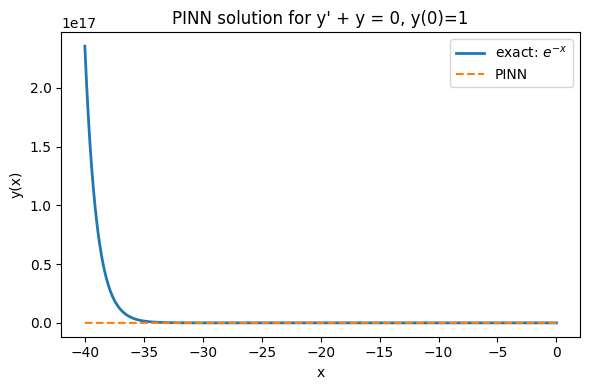

In [73]:
with torch.no_grad():
  x_plot = torch.linspace(-40, 0, 20000, device='cpu').unsqueeze(1)
  y_pred = model(x_plot)
  y_true = exact_solution(x_plot)

x_np = x_plot.cpu().numpy().squeeze()
y_pred_np = y_pred.numpy().squeeze()
y_true_np = y_true.numpy().squeeze()
plt.figure(figsize=(6, 4))
plt.plot(x_np, y_true_np, label=r"exact: $e^{-x}$", linewidth=2)
plt.plot(x_np, y_pred_np, label="PINN", linestyle="--")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("PINN solution for y' + y = 0, y(0)=1")
plt.legend()
plt.tight_layout()
plt.show()

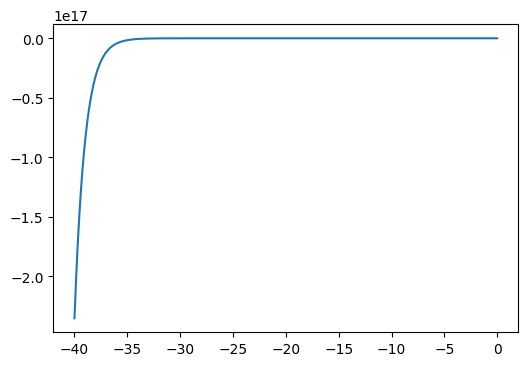

In [76]:
z = y_pred_np - y_true_np
plt.figure(figsize=(6, 4))
plt.plot(x_np, z)
plt.show()

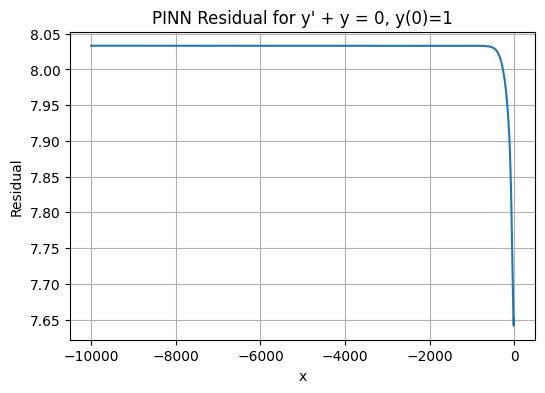

In [75]:
x = torch.linspace(-10000, -10, 20000, device='cpu').unsqueeze(1)
x.requires_grad_(True)
y = model(x)
dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
        )[0]
residual = dy_dx + y

x_numpy = x.detach().numpy().squeeze()
y_numpy = y.detach().numpy().squeeze()
dy_dx_numpy = dy_dx.detach().numpy().squeeze()
residual_numpy = residual.detach().numpy().squeeze()

plt.figure(figsize=(6, 4))
plt.plot(x_numpy, residual_numpy)
plt.xlabel("x")
plt.ylabel("Residual")
plt.title("PINN Residual for y' + y = 0, y(0)=1")
plt.grid(True)
plt.show()

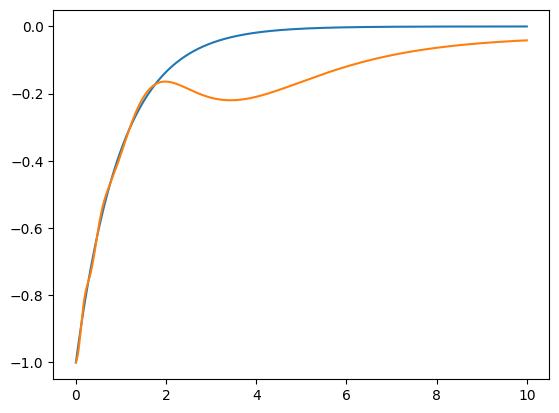

In [93]:
def true_derivative(x):
  return -np.exp(-x)

x = torch.linspace(0,10,1000, device='cpu').unsqueeze(1)
x.requires_grad_(True)
y = model(x)
dy_dx = torch.autograd.grad(
    y,x, grad_outputs=torch.ones_like(y),
    create_graph=True, retain_graph=True
    )[0]

x_numpy = x.detach().numpy().squeeze()
y_numpy = y.detach().numpy().squeeze()
dy_dx_numpy = dy_dx.detach().numpy().squeeze()
y_t = true_derivative(x_numpy)
plt.plot(x_numpy,y_t)
plt.plot(x_numpy,dy_dx_numpy)
plt.show()